In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from google.colab import drive

drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Colab Notebooks/dataset/Bike_sharing/'

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv(data_path+'train.csv',header=0,delimiter=',',quoting=3,parse_dates=['datetime'])
test_data = pd.read_csv(data_path+'test.csv',header=0,delimiter=',',quoting=3,parse_dates=['datetime'])
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
train_data.temp.describe()

In [ ]:
train_label = train_data['count']
train_label.head()
print(train_label.shape)

(10886,)


In [ ]:
train_data['year']=train_data['datetime'].dt.year
train_data['month']=train_data['datetime'].dt.month
train_data['day']=train_data['datetime'].dt.day
train_data['hour']=train_data['datetime'].dt.hour
train_data['minute']=train_data['datetime'].dt.minute
train_data['second']=train_data['datetime'].dt.second
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


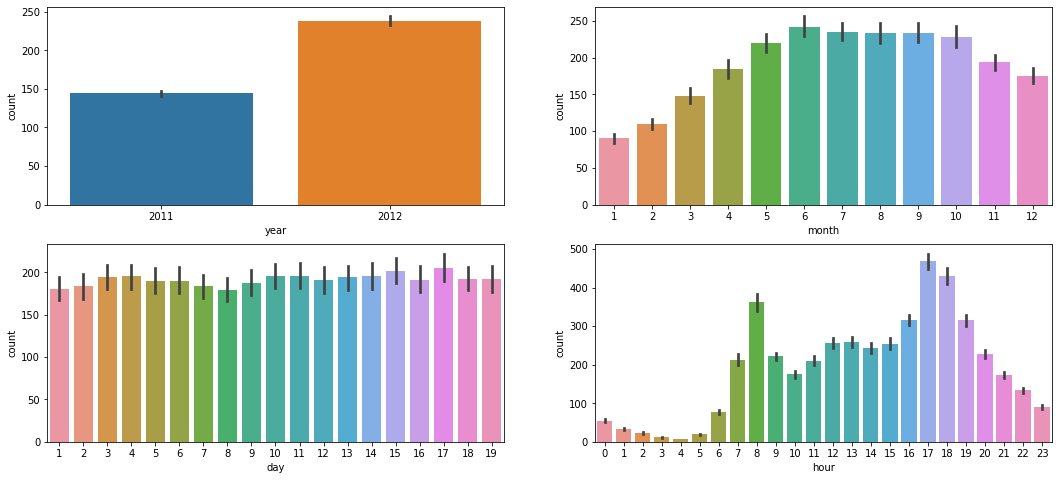

In [ ]:
import seaborn as sns
figure,((ax1,ax2),(ax3,ax4))=plt.subplots(nrows=2,ncols=2)
figure.set_size_inches(18,8)
sns.barplot(data=train_data,x='year',y='count',ax=ax1)
sns.barplot(data=train_data,x='month',y='count',ax=ax2)
sns.barplot(data=train_data,x='day',y='count',ax=ax3)
sns.barplot(data=train_data,x='hour',y='count',ax=ax4)
#hour,year,month data.

In [ ]:
train_data['dayofweek']=train_data['datetime'].dt.dayofweek
train_data['dayofweek'].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

In [ ]:
figure,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=4)
figure.set_size_inches(15,25)
sns.pointplot(data=train_data,x='hour',y='count',hue='dayofweek',ax=ax1)
sns.pointplot(data=train_data,x='hour',y='count',hue='workingday',ax=ax2)
sns.pointplot(data=train_data,x='hour',y='count',hue='weather',ax=ax3)
sns.pointplot(data=train_data,x='hour',y='count',hue='season',ax=ax4)
#dayofweek(요일)
#workingday(Bday or not)
#season은 month로 치환 가능

In [ ]:
#correlation Matrix heatmap
corrMatt = train_data[['temp','atemp','casual','registered','humidity','windspeed','count']]
corrMatt = corrMatt.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)]=False
print(corrMatt)

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(20,20)
sns.heatmap(corrMatt,mask=mask,vmax=.8,square=True,annot=True)
#humidity는 상관관계 -0.32, windspeed는 0.1로 거의 상관 X
#casual과 registered는 train에만 있음 => 사용 X

In [ ]:
def concatenate_ym(datetime):
    return '{0}-{1}'.format(datetime.year,datetime.month)
train_data['year-month'] = train_data['datetime'].apply(concatenate_ym)
train_data[['datetime','year-month']].head()

,datetime,year-month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


In [ ]:
#6sigma 이내의 데이터만 취급
trainwoOutliers = train_data[np.abs(train_data['count']-train_data['count'].mean()) <= (3*train_data['count'].std())]

trainwoOutliers.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek,year-month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5,2011-1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5,2011-1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5,2011-1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5,2011-1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5,2011-1


In [ ]:
x_train = trainwoOutliers[['season','workingday','weather','temp','atemp','humidity','windspeed','dayofweek']]
test_data['dayofweek'] = test_data['datetime'].dt.dayofweek
x_test = test_data[['season','holiday','weather','temp','atemp','humidity','windspeed','dayofweek']]
y_train = trainwoOutliers['count']
x_train.head()


,season,workingday,weather,temp,atemp,humidity,windspeed,dayofweek
0,1,0,1,9.84,14.395,81,0.0,5
1,1,0,1,9.02,13.635,80,0.0,5
2,1,0,1,9.02,13.635,80,0.0,5
3,1,0,1,9.84,14.395,75,0.0,5
4,1,0,1,9.84,14.395,75,0.0,5


In [ ]:
print(refined_train_data.shape)
print(refined_train_label.shape)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(x_test)

In [ ]:
from sklearn.metrics import make_scorer

def rmsle(predict,actual):
    predict_val = np.array(predict)
    actual_val = np.array(actual)

    log_predict = np.log(predict_val+1)
    log_actual = np.log(actual_val+1)

    diff = log_predict-log_actual

    diff = np.square(diff)

    mean_diff = diff.mean()

    score = np.sqrt(mean_diff)

    return score
rmsle_scorer = make_scorer(rmsle)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score,KFold

k_fold = KFold(n_splits=10,shuffle=True,random_state=0)

max_depth_list = []
model = RandomForestRegressor(n_estimators = 100,n_jobs=1,random_state=0)

score = cross_val_score(model,x_train,y_train,cv=k_fold,scoring=rmsle_scorer)
score = score.mean()
model.fit(x_train,y_train)
pred = model.predict(x_test)

print(pred.shape)

(6493,)


In [ ]:
print(score)

1.2126211825636701


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


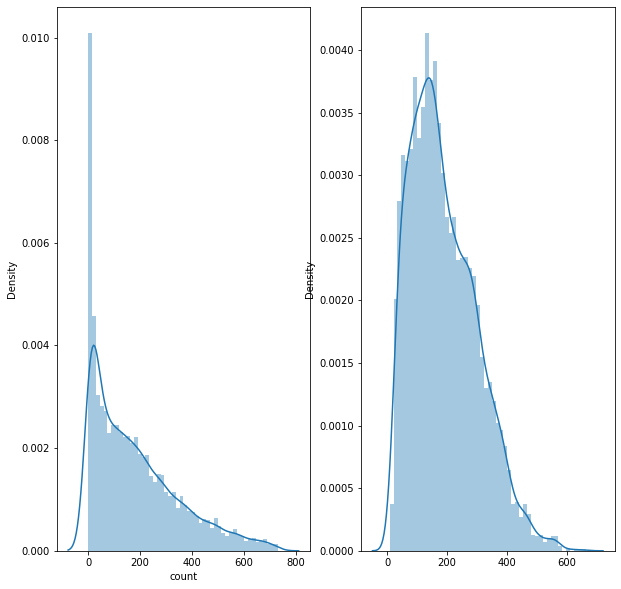

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,10)
sns.distplot(y_train,ax = ax1,bins=50)
sns.distplot(pred,bins=50,ax=ax2)

In [ ]:
model = Sequential()
model.add(Dense(64,input_shape=(x_train.shape[1],),activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.01),loss='mse',metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_9 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 83,265
Trainable params: 83,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train,y_train,epochs=100)

Epoch 1/100
336/336 [==============================] - 1s 2ms/step - loss: 25079.1281 - mae: 118.5320
Epoch 2/100
336/336 [==============================] - 1s 2ms/step - loss: 20522.7715 - mae: 108.0497
Epoch 3/100
336/336 [==============================] - 1s 2ms/step - loss: 21349.1566 - mae: 110.8767
Epoch 4/100
336/336 [==============================] - 1s 2ms/step - loss: 20776.9639 - mae: 108.5419
Epoch 5/100
336/336 [==============================] - 1s 2ms/step - loss: 20643.8602 - mae: 108.4714
Epoch 6/100
336/336 [==============================] - 1s 2ms/step - loss: 20858.8131 - mae: 109.5471
Epoch 7/100
336/336 [==============================] - 1s 2ms/step - loss: 19312.4486 - mae: 105.0542
Epoch 8/100
336/336 [==============================] - 1s 2ms/step - loss: 19935.9569 - mae: 106.2153
Epoch 9/100
336/336 [==============================] - 1s 2ms/step - loss: 19981.6681 - mae: 106.6984
Epoch 10/100
336/336 [==============================] - 1s 2ms/step - loss: 20101.

In [ ]:
prediction = model.predict(x_test)
for i in range(100):
    print(prediction[i])

[75.2634]
[83.58885]
[83.58885]
[80.31464]
[80.31464]
[68.39136]
[64.50789]
[67.84427]
[65.979645]
[80.0486]
[92.35042]
[105.41586]
[107.937256]
[107.09506]
[113.10428]
[123.064896]
[107.26953]
[106.956726]
[82.08893]
[76.80681]
[65.34605]
[57.55607]
[57.55607]
[57.55607]
[57.55607]
[57.55607]
[59.36203]
[57.55607]
[74.7926]
[57.55607]
[70.28703]
[57.55607]
[57.55607]
[57.55607]
[57.55607]
[57.55607]
[99.22774]
[96.57503]
[94.556046]
[80.32779]
[85.06702]
[67.64569]
[68.89903]
[57.55607]
[57.55607]
[47.44134]
[47.12221]
[46.724487]
[45.99141]
[46.73164]
[46.89178]
[46.798733]
[46.003555]
[46.792454]
[46.520267]
[46.510338]
[46.676758]
[46.91219]
[47.067825]
[45.427143]
[35.668518]
[66.53761]
[31.330727]
[81.514465]
[40.435745]
[47.40666]
[46.618298]
[45.58138]
[45.521378]
[58.948444]
[46.367714]
[46.445004]
[46.445004]
[45.94759]
[45.94759]
[46.66003]
[46.66003]
[45.2685]
[45.367493]
[45.262646]
[58.444725]
[48.85989]
[57.55607]
[57.55607]
[87.989685]
[87.989685]
[83.45825]
[69.74335]
